In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
from matplotlib import pyplot as plt
import matplotlib
import fastText
import html
import string
import nltk
from multiprocessing import Process
import multiprocessing
import time
import sys
from importlib import reload
import redis
# from urllib import request
from urllib.parse import urlparse
import requests as req
# from lxml import html
import logging
# from scrapy.http import Request
import requests
import json
import requests
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
import re
from collections import Counter
from sklearn.metrics import precision_recall_curve
from tabulate import tabulate
from nltk.metrics import ConfusionMatrix
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from gensim.models import Word2Vec
import mpld3
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer


mpld3.enable_notebook()
%matplotlib inline

In [5]:
import preprocess as pp
pp = reload(pp)

In [6]:
df_comparisons = pd.read_csv('df_comparisons_init.csv', index_col=0)
df_news = pd.read_csv('df_news_init.csv',  parse_dates=['Datetime', 'Date'], index_col=0)

In [7]:
df_news.spot.fillna('', inplace = True)
df_news.body.fillna('', inplace = True)
df_news.title.fillna('', inplace = True)

In [8]:
def numerize_repeats(wordlist):
    counts = {}
    outlist = []
    for word in wordlist:
        if word in counts:
            outlist.append(word + '_' + str(counts[word]))
            counts[word] += 1
        else:
            outlist.append(word)
            counts[word] = 1
    return outlist

In [9]:
df_news['text_pp'] = df_news.apply(lambda x: pp.preprocess02(x.title + ' ' + x.spot + ' ' + x.body, tokenize=True), axis=1)
df_news['title_pp'] = df_news.apply(lambda x: pp.preprocess02(x.title, tokenize=True), axis=1)
df_news['spot_pp'] = df_news.apply(lambda x: pp.preprocess02(x.spot, tokenize=True), axis=1)

__Populate Scores__

In [10]:
methods = ['ju','js','jc','ft', 'wv']
fields = ['text','title','spot']
methods_cross = [met + '_' + field for met in methods for field in fields]

In [11]:
ftmodel = fastText.load_model('../../data/model/downloads/reaction.all.1544796200.punct_True.stopwords_False.lemmatized_False.E100.bin')

In [13]:
model_w2v = Word2Vec.load('/models/reaction.all.1544173485.punct_True.stopwords_False.lemmatized_False.w2v_100V_5E_1547558000.bin')

In [14]:
def get_w2v_vector(words_now):
    
    vecnow = np.zeros((model_w2v.wv.vector_size,))
    count = 0
    
    for word in words_now:
        if word in model_w2v.wv.vocab:
            vecnow += model_w2v.wv.word_vec(word)
            count += 1
            
    if count == 0:
        return vecnow
    else:
        return vecnow / count

In [15]:
for field in fields:
    
    print(field)
    
    for index, row in df_comparisons.iterrows():

        # JU, JS and JC scores
        sent1 = df_news.iloc[int(row.ind0)][field + '_pp']
        sent2 = df_news.iloc[int(row.ind1)][field + '_pp']
        
        if len(sent1) == 0 and len(sent2) == 0:
            score_ju = -1
            score_js = -1
            score_jc = -1
        else:
            sent1_set = set(sent1)
            sent2_set = set(sent2)
            
            sent_inter = sent1_set.intersection(sent2_set)
            sent_union = sent1_set.union(sent2_set)

            score_ju = len(sent_inter) / len(sent_union)
            
            if len(sent1) == 0 or len(sent2) == 0:
                score_js = -1
            else:
                score_js = len(sent_inter) / min(len(sent1), len(sent2))

            sent1_num = set(numerize_repeats(sent1))
            sent2_num = set(numerize_repeats(sent2))

            score_jc = len(sent1_num.intersection(sent2_num)) / len(sent1_num.union(sent2_num))  

        # Word Embedding Scores
        sent1 = ' '.join(sent1)
        sent2 = ' '.join(sent2)
        
        if len(sent1) == 0 or len(sent2) == 0:
            score_wv = -1
        else:
            vec1 = get_w2v_vector(sent1.split())
            vec2 = get_w2v_vector(sent2.split())
            score_wv = float(cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1)).flatten()[0])
        
        if sent1 == '' or sent2 == '':
            score_ft = -1
        else:
            vec1 = ftmodel.get_sentence_vector(sent1)
            vec2 = ftmodel.get_sentence_vector(sent2)
            score_ft = float(cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1)).flatten()[0])

        # Write scores to the dataframe
        df_comparisons.loc[index, 'ju_'+field] = score_ju
        df_comparisons.loc[index, 'js_'+field] = score_js
        df_comparisons.loc[index, 'jc_'+field] = score_jc
        df_comparisons.loc[index, 'ft_'+field] = score_ft
        df_comparisons.loc[index, 'wv_'+field] = score_wv

text
title
spot


In [16]:
df_comparisons_bu = df_comparisons.copy()

In [17]:
df_comparisons = df_comparisons_bu.copy()

In [18]:
for met in methods:
    for field in fields:
        colnow = met+'_'+field
        missings_now = df_comparisons_bu[colnow] == -1
        meannow = df_comparisons_bu[~missings_now][colnow].mean()
        df_comparisons.loc[missings_now, colnow] = meannow
        print(colnow, missings_now.sum(), meannow)

ju_text 0 0.08576513223884118
ju_title 13 0.04466779784696574
ju_spot 1 0.06268945921431457
js_text 0 0.1181847570755424
js_title 913 0.07313392915227346
js_spot 241 0.09800768648331443
jc_text 0 0.07931630538917922
jc_title 13 0.04444942226155838
jc_spot 1 0.06116419775773856
ft_text 0 0.8036005140333813
ft_title 913 0.5948695254469785
ft_spot 241 0.70987172767259
wv_text 0 0.810817939909232
wv_title 913 0.6001549026717473
wv_spot 241 0.7169804563212375


In [19]:
for met in methods:
    for field in fields:
        colnow = met+'_'+field
        missings_now = df_comparisons[colnow] == -1
        meannow = df_comparisons[~missings_now][colnow].mean()
        print(colnow, missings_now.sum(), meannow)

ju_text 0 0.08576513223884118
ju_title 0 0.04466779784696575
ju_spot 0 0.06268945921431457
js_text 0 0.1181847570755424
js_title 0 0.07313392915227344
js_spot 0 0.09800768648331441
jc_text 0 0.07931630538917922
jc_title 0 0.04444942226155839
jc_spot 0 0.061164197757738556
ft_text 0 0.8036005140333813
ft_title 0 0.5948695254469786
ft_spot 0 0.7098717276725899
wv_text 0 0.810817939909232
wv_title 0 0.6001549026717473
wv_spot 0 0.7169804563212375


In [20]:
df_comparisons.head()

ind0  ind1  label   ju_text   js_text   jc_text   ft_text   wv_text  \
0     0     1    1.0  1.000000  0.801325  0.915152  0.999338  0.999352   
1     0     2    1.0  0.388571  0.450331  0.421296  0.992130  0.993333   
2     0     3    1.0  0.382022  0.450331  0.394850  0.992452  0.992867   
3     1     2    1.0  0.388571  0.435897  0.401747  0.991408  0.993187   
4     1     3    1.0  0.382022  0.412121  0.418410  0.992790  0.993977   

   ju_title  js_title  jc_title  ft_title  wv_title   ju_spot   js_spot  \
0       1.0       1.0       1.0       1.0       1.0  0.823529  1.000000   
1       1.0       1.0       1.0       1.0       1.0  0.545455  0.705882   
2       1.0       1.0       1.0       1.0       1.0  0.409091  0.642857   
3       1.0       1.0       1.0       1.0       1.0  0.409091  0.642857   
4       1.0       1.0       1.0       1.0       1.0  0.473684  0.642857   

    jc_spot   ft_spot   wv_spot  
0  0.823529  0.986581  0.991020  
1  0.545455  0.990459  0.991918  
2  0.409091  0.972439  0.979608  
3  0.409091  0.978322  0.983968  
4  0.473684  0.987097  0.989496

In [21]:
def prec_recall(tp, fp, fn):

    return float(tp / (tp + fp)), float(tp / (tp + fn))

def find_eacc(labels_now, preds_now):
    labels_now = labels_now.flatten()
    preds_now = preds_now.flatten()
    
    precs, recalls, thresholds = precision_recall_curve(labels_now, preds_now)
    
    indnow = np.argmin(np.abs(precs-recalls))
    eacc = (precs[indnow] + recalls[indnow]) / 2
    thr = thresholds[indnow]
    
    true_positive = np.logical_and(preds_now>=thr, labels_now==1).sum()
    true_negative = np.logical_and(preds_now<thr, labels_now==0).sum()
    false_positive = np.logical_and(preds_now>=thr, labels_now==0).sum()
    false_negative = np.logical_and(preds_now<thr, labels_now==1).sum()
    
    precision, recall = prec_recall(true_positive, false_positive, false_negative)
    
    f1 = 2*(recall * precision) / (recall + precision)
    
    out = dict(thr=thr,eacc=eacc, precision=precision, recall=recall, f1=f1,
              tp=true_positive, tn=true_negative,
               fp=false_positive, fn=false_negative,
               precs=precs, recalls=recalls
               )
    
    return out

In [22]:
results = {}
for met in methods:
    for field in fields:
        method = met + '_' + field
        results[method] = find_eacc(df_comparisons.label.values, df_comparisons[method].values) 

In [23]:
def tabulate_res(resnow):

    table = []
    for key, val in resnow.items():
        table.append(
            [key, resnow[key]['eacc'], resnow[key]['f1'], resnow[key]['precision'], resnow[key]['recall'], resnow[key]['thr'], resnow[key]['tp'], resnow[key]['tn'], resnow[key]['fp'],
             resnow[key]['fn']])

    return tabulate(table, headers=['', 'E-ACC', 'F1', 'PREC', 'RECALL', 'THR', 'TP', 'TN', 'FP', 'FN'], tablefmt="fancy_grid")

In [25]:
print(tabulate_res(results))

╒══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤══════╤═══════╤══════╤══════╕
│          │    E-ACC │       F1 │     PREC │   RECALL │       THR │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪══════╪═══════╪══════╪══════╡
│ ju_text  │ 0.96394  │ 0.96394  │ 0.96394  │ 0.96394  │ 0.0925926 │ 1791 │ 14933 │   67 │   67 │
├──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼──────┼───────┼──────┼──────┤
│ ju_title │ 0.814897 │ 0.814854 │ 0.809019 │ 0.820775 │ 0.0833333 │ 1525 │ 14640 │  360 │  333 │
├──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼──────┼───────┼──────┼──────┤
│ ju_spot  │ 0.93693  │ 0.936927 │ 0.938445 │ 0.935414 │ 0.0722892 │ 1738 │ 14886 │  114 │  120 │
├──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼──────┼───────┼──────┼──────┤
│ js_text  │ 0.946179 │ 0.946179 │ 0.946179 │ 0.946179 │ 0.201058  │ 1758 │ 14900 │  100 │  100 │
├──────────┼────────

In [96]:
def plot_pr_curve(resnow):
    
    fig = plt.figure(figsize=[8,8]);
    colors = 'bgrymk'
    count = 0
    for key, val in resnow.items():
        plt.step(val['recalls'], val['precs'], color=colors[count], alpha=0.2, linewidth=4,linestyle='--',
                 where='post')
        count += 1

    plt.plot([0,1], [0,1]);
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid();
    plt.legend([keynow for keynow in resnow.keys()]);

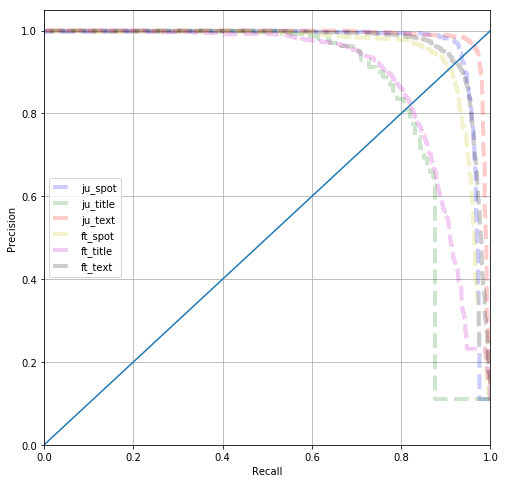

In [97]:
plot_pr_curve({key: results[key] for key in ['ju_spot', 'ju_title', 'ju_text', 'ft_spot', 'ft_title', 'ft_text']})

In [26]:
def normalize_score(dfnow, colname, thrnow):
    
    stdnow = dfnow[colname].std()
    
    print("%s\t==>\tstd: %.4f, old_thr: %.4f" % (colname, stdnow, thrnow))
    
    return (dfnow[colname] - thrnow ) / stdnow, stdnow

In [27]:
for method in methods_cross:
    dsnow, stdnow = normalize_score(df_comparisons, method, results[method]['thr'])
    df_comparisons[method+'_norm'] = dsnow
    results[method]['std_norm'] = stdnow

ju_text	==>	std: 0.1862, old_thr: 0.0926
ju_title	==>	std: 0.1502, old_thr: 0.0833
ju_spot	==>	std: 0.1847, old_thr: 0.0723
js_text	==>	std: 0.1560, old_thr: 0.2011
js_title	==>	std: 0.2001, old_thr: 0.2000
js_spot	==>	std: 0.2211, old_thr: 0.1818
jc_text	==>	std: 0.1758, old_thr: 0.0897
jc_title	==>	std: 0.1498, old_thr: 0.0833
jc_spot	==>	std: 0.1826, old_thr: 0.0690
ft_text	==>	std: 0.0909, old_thr: 0.9271
ft_title	==>	std: 0.1318, old_thr: 0.7517
ft_spot	==>	std: 0.1156, old_thr: 0.8608
wv_text	==>	std: 0.0908, old_thr: 0.9323
wv_title	==>	std: 0.1418, old_thr: 0.7692
wv_spot	==>	std: 0.1182, old_thr: 0.8709


In [28]:
methods_cross_norm = [met+'_norm' for met in methods_cross]

In [29]:
field_weights = {'spot': 0.3, 'title': 0.1, 'text': 0.6}

In [30]:
def weighted_av(rownow, weights_field, metsnow):
    
    score = 0
    count = 0
    
    for method in metsnow:
        count += 1
        for field in fields:
            score += weights_field[field] * rownow[method + '_' + field + '_norm']
            
    return score / count

In [31]:
for met in methods:
    df_comparisons[met + '_all'] = df_comparisons.apply(lambda row: weighted_av(row, field_weights, [met]), axis=1)
    results.update({met + '_all': find_eacc(df_comparisons.label.values, df_comparisons[met + '_all'].values)})

In [32]:
df_comparisons['comb'] = df_comparisons.apply(lambda row: weighted_av(row, field_weights, methods), axis=1)

In [33]:
df_comparisons['comb_wm'] = df_comparisons.apply(lambda row: weighted_av(row, field_weights, ['ju','js','jc']), axis=1)

In [34]:
df_comparisons['comb_we'] = df_comparisons.apply(lambda row: weighted_av(row, field_weights, ['ft','wv']), axis=1)

In [36]:
results.update({met: find_eacc(df_comparisons.label.values, df_comparisons[met].values) for met in methods_cross_norm + ['comb', 'comb_wm', 'comb_we']})

In [38]:
print(tabulate_res(results))

╒═══════════════╤══════════╤══════════╤══════════╤══════════╤════════════╤══════╤═══════╤══════╤══════╕
│               │    E-ACC │       F1 │     PREC │   RECALL │        THR │   TP │    TN │   FP │   FN │
╞═══════════════╪══════════╪══════════╪══════════╪══════════╪════════════╪══════╪═══════╪══════╪══════╡
│ ju_text       │ 0.96394  │ 0.96394  │ 0.96394  │ 0.96394  │  0.0925926 │ 1791 │ 14933 │   67 │   67 │
├───────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ ju_title      │ 0.814897 │ 0.814854 │ 0.809019 │ 0.820775 │  0.0833333 │ 1525 │ 14640 │  360 │  333 │
├───────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ ju_spot       │ 0.93693  │ 0.936927 │ 0.938445 │ 0.935414 │  0.0722892 │ 1738 │ 14886 │  114 │  120 │
├───────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ js_text       │ 0.946179 │ 0.946179 │ 0.946179 │ 0.946179 │  0

In [39]:
df_comparisons.to_csv('df_comparisons_unsup.csv')

In [40]:
for field in fields:
    df_news[field+'_pp_str'] = df_news[field+'_pp'].apply(lambda x: ' '.join(x))
    df_news[field+'_pp_str'].fillna('', inplace=True)

In [41]:
df_news.to_csv('df_news_unsup.csv')

In [42]:
with open('unsupervised_results.pickle', 'wb') as f:
    pickle.dump(results, f)

In [45]:
results['comb']

{'thr': -0.0363691467748684,
 'eacc': 0.9833153928955867,
 'precision': 0.9833153928955867,
 'recall': 0.9833153928955867,
 'f1': 0.9833153928955867,
 'tp': 1827,
 'tn': 14969,
 'fp': 31,
 'fn': 31,
 'precs': array([0.33013504, 0.33001599, 0.33007465, ..., 1.        , 1.        ,
        1.        ]),
 'recalls': array([1.00000000e+00, 9.99461787e-01, 9.99461787e-01, ...,
        1.07642626e-03, 5.38213132e-04, 0.00000000e+00])}